# An interpretable prediction system for the Site Of Origin (SOO) of Outflow Tract Ventricular Arrhythmias (OTVAs)

## 0. Starting point

See first the [README](README.md) for a general introduction to the project. We will start analyzing what we have as input, and how will we approach the tasks given our restrictions (dataset, interpretability, fast inference).

### 0.1. About the dataset

We were provided with a dataset with anonymous data from Teknon Medical Center, Barcelona, Spain. As explained in the [release](https://github.com/uripont/arrhythmia-origin-predictor/releases/download/dataset/dataset_arrhythmias.zip), the dataset contains electrocardiogram (ECG) recordings and demographic information from patients with Outflow Tract Ventricular Arrhythmias (OTVAs). Each case includes several 12-lead ECG signal segment (of 2.5 seconds), patient demographic data (age, sex, height, weight,...), and clinician-validated labels indicating the arrhythmia's Site of Origin (SOO). The SOO labels include Left Ventricular Outflow Tract (LVOT), Right Ventricular Outflow Tract (RVOT), and for LVOT cases, further classification into Right Coronary Cusp (RCC) or aortomitral commissure origins among others. 

The following code retrieves the dataset from the release and unzips it into `dataset/` folder, from which we will later load the data and perform the preprocessing. This allows 1:1 reproducibility of the results by performing this notebook's logic on the same input data.


In [1]:
# Standard library packages:
import os
import urllib.request
import zipfile
import shutil
import pickle

# Third-party packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#TODO: add missing here and on requirements.txt

 
# If running this notebook produces import errors, please install missing packages:
# pip install -r requirements.txt
# 
# Consider using a virtual environment:
# python -m venv venv
# source venv/bin/activate  # On Windows: venv\Scripts\activate

In [2]:
# URL of the dataset zip file
dataset_url = "https://github.com/uripont/arrhythmia-origin-predictor/releases/download/dataset/dataset_arrhythmias.zip"

In [3]:
# Local paths
zip_path = "dataset_arrhythmias.zip"
extract_dir = "dataset"

# Create dataset directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Download the zip file
if not os.path.exists(zip_path):
    print(f"Downloading dataset from {dataset_url}...")
    urllib.request.urlretrieve(dataset_url, zip_path)
    print(f"Download complete. Saved to {zip_path}")
else:
    print(f"Dataset zip file already exists at {zip_path}")

# Extract the contents only if the directory is empty or doesn't exist
if not os.path.exists(extract_dir) or not os.listdir(extract_dir):
    print(f"Extracting files to {extract_dir}/")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset is ready in the '{extract_dir}' directory.")
else:
    print(f"Extraction directory already exists: {extract_dir}/")

Dataset zip file already exists at dataset_arrhythmias.zip
Extraction directory already exists: dataset/


In [4]:
# Print the contents of the extracted directory, filtering out hidden files/folders
extracted_files = [f for f in os.listdir(extract_dir) 
                  if not f.startswith('.') and not f.startswith('__')]
print("Extracted files:")
for file in extracted_files:
    print(f"- {file}")

Extracted files:
- label2.xlsx
- labels_FontiersUnsupervised.xlsx
- all_points_may_2024.pkl


### 0.2. Patient cases

//TODO: explain how the patient cases are structured on the data file, how we extract them, how many cases we have, what we will consider as a case (demographic data + an ECG worth of data).

## 1. Our approach

//TODO: explain system of models, Model A for dimensionality reduction of ECGs, merge this with the encoded demographic data, and then do a filtering step (remove either the SOO or the sub-region) so that we are left with a single target variable, and then train Model B and Model C for classification of the SOO and sub-regions respectively.

//TODO: explain how we want to give basically all variability of the dataset to the classification model, but first preprocessing it to represent this same data in a much smaller dimensionality that corresponds to learned, interpretable features.

//TODO: explain how we do transformations of the loaded dataset (dataframe) to clean it/reduce it, inspired by RDD's

//TODO: explain what families and kinds of models we are considering for both the dimensionality reduction and the classification, as well as how we plan to use multiple model training and evaluation to find the best performing models for each task.


## 2. Demographic data preprocessing

We start by loading the demographic data from the dataset, which is spread out between all 3 different extracted files. We want to clean it up and have a clear set of demographic features per patient.

We start by displaying all data from the `.pkl` file, to see the broader structure of the nested dictionaries that this file contains:

In [5]:
data = pickle.load(open(os.path.join(extract_dir, 'all_points_may_2024.pkl'), 'rb'))
data = pd.DataFrame(data).T

display(data.head())

,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin,Structures
P186,[Female],[nan],[61.0],[V1],[Right ventricle],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[Unión mitroaórtica],[0.0],{'2-LV': {'P36': {'I': [-0.075 -0.075 -0.072 ....
P245,[Female],[No],[52.0],[V3],[RVOT],[169.0],[68.0],[nan],[No],[No],[No],[No],[No],[1.0],[Pared libre anterior],[1.0],{'2-RV': {'P157': {'I': [ 0. 0. 0. ...
P292,[Female],[No],[69.0],[V3],[LVOT],[156.0],[70.0],[nan],[No],[Yes],[No],[No],[No],[1.0],[RCC],[1.0],{'2-AO': {'P55': {'I': [-0.063 -0.051 -0.03 ....
P205,[Female],[No],[66.0],[V4],[Right ventricle],[176.0],[63.0],[20.33832644628099],[No],[No],[No],[No],[No],[1.0],[M. papilar posteromedial],[0.0],{'2-1-Rp-LV': {'P320': {'I': [-0.297 -0.288 -0...
P066,[Female],[Yes],[46.0],[V3],[RVOT],[160.0],[79.0],[30.85937499999999],[No],[No],[No],[No],[No],[1.0],[RVOT septal],[1.0],{'1-PA': {'P13': {'I': [-0.006 -0.003 -0.003 ....


In [6]:
# Print initial .pkl dataframe shape
print(f"Initial DataFrame shape: {data.shape}")

Initial DataFrame shape: (190, 17)


We can see that the data is structured in a way that each row corresponds to a patient, and each column corresponds to a demographic feature, except for the `Structures` column, which contains nested dictionaries with several different ECGs for each individual patient.

In [7]:
data.drop(columns=['Structures'], inplace=True)
display(data.head())

,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin
P186,[Female],[nan],[61.0],[V1],[Right ventricle],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[Unión mitroaórtica],[0.0]
P245,[Female],[No],[52.0],[V3],[RVOT],[169.0],[68.0],[nan],[No],[No],[No],[No],[No],[1.0],[Pared libre anterior],[1.0]
P292,[Female],[No],[69.0],[V3],[LVOT],[156.0],[70.0],[nan],[No],[Yes],[No],[No],[No],[1.0],[RCC],[1.0]
P205,[Female],[No],[66.0],[V4],[Right ventricle],[176.0],[63.0],[20.33832644628099],[No],[No],[No],[No],[No],[1.0],[M. papilar posteromedial],[0.0]
P066,[Female],[Yes],[46.0],[V3],[RVOT],[160.0],[79.0],[30.85937499999999],[No],[No],[No],[No],[No],[1.0],[RVOT septal],[1.0]


Having removed these for now, we'll focus on the other 16 columns (demographic data), which we will preprocess now. We start by flattening out the current lists of values in indivudal cells, as can be seen from previous cell outputs, so that they are just single values:

In [8]:
def remove_lists(x):
    if isinstance(x, list):
        if len(x) == 1:
            return x[0]  # Return single value
        elif len(x) == 0:
            return np.nan  # Empty list returns NaN
        else:
            return ', '.join(str(i) for i in x)  # Multiple elements return string
    return x  # If not a list, return as is

data = data.transform(lambda s: s.map(remove_lists))
display(data)

,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin
P186,Female,NaN,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unión mitroaórtica,0.0
P245,Female,No,52.0,V3,RVOT,169.0,68.0,NaN,No,No,No,No,No,1.0,Pared libre anterior,1.0
P292,Female,No,69.0,V3,LVOT,156.0,70.0,NaN,No,Yes,No,No,No,1.0,RCC,1.0
P205,Female,No,66.0,V4,Right ventricle,176.0,63.0,20.338326,No,No,No,No,No,1.0,M. papilar posteromedial,0.0
P066,Female,Yes,46.0,V3,RVOT,160.0,79.0,30.859375,No,No,No,No,No,1.0,RVOT septal,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P018,Male,Yes,61.0,V1,Right ventricle,188.0,90.0,25.464011,No,No,No,No,No,3.0,LV summit,0.0
P124,Male,Yes,52.0,V3,LVOT,182.0,83.0,25.057360,No,No,No,No,No,3.0,Seno de Valsalva dcho.,1.0
P171,Male,No,77.0,V6,Right ventricle,NaN,NaN,NaN,No,No,No,No,No,2.0,LV inferobasal,0.0
P219,Male,Yes,88.0,V1,Mitral annulus,166.0,90.0,NaN,Yes,Yes,No,No,No,3.0,Anillo mitral anterolateral,0.0


In [9]:
def convert_to_binary(value, true_value, false_value):
    if pd.isna(value):
        return None
    elif value == true_value:
        return 1
    elif value == false_value:
        return 0
    return None

def apply_binary_conversion(df, columns_dict):
    print("Converting categorical columns to binary:")
    for column, (true_value, false_value) in columns_dict.items():
        initial_count = df[column].notna().sum()
        
        df[column] = df[column].apply(lambda x: convert_to_binary(x, true_value, false_value))

        null_count = df[column].isna().sum()     
        print(f"- {column}: {initial_count - null_count} converted, "
              f"{null_count} null")
    
    return df

binary_columns = {
    'Sex': ('Female', 'Male'),
    'HTA': ('Yes', 'No'),
    'DM': ('Yes', 'No'),
    'DLP': ('Yes', 'No'),
    'Smoker': ('Yes', 'No'),
    'COPD': ('Yes', 'No'),
    'Sleep_apnea': ('Yes', 'No')
}

data = apply_binary_conversion(data, binary_columns)
display(data)

Converting categorical columns to binary:
- Sex: 184 converted, 3 null
- HTA: 176 converted, 7 null
- DM: 174 converted, 8 null
- DLP: 176 converted, 7 null
- Smoker: 172 converted, 9 null
- COPD: 174 converted, 8 null
- Sleep_apnea: 172 converted, 9 null


,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin
P186,1.0,NaN,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unión mitroaórtica,0.0
P245,1.0,0.0,52.0,V3,RVOT,169.0,68.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,Pared libre anterior,1.0
P292,1.0,0.0,69.0,V3,LVOT,156.0,70.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,RCC,1.0
P205,1.0,0.0,66.0,V4,Right ventricle,176.0,63.0,20.338326,0.0,0.0,0.0,0.0,0.0,1.0,M. papilar posteromedial,0.0
P066,1.0,1.0,46.0,V3,RVOT,160.0,79.0,30.859375,0.0,0.0,0.0,0.0,0.0,1.0,RVOT septal,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P018,0.0,1.0,61.0,V1,Right ventricle,188.0,90.0,25.464011,0.0,0.0,0.0,0.0,0.0,3.0,LV summit,0.0
P124,0.0,1.0,52.0,V3,LVOT,182.0,83.0,25.057360,0.0,0.0,0.0,0.0,0.0,3.0,Seno de Valsalva dcho.,1.0
P171,0.0,0.0,77.0,V6,Right ventricle,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2.0,LV inferobasal,0.0
P219,0.0,1.0,88.0,V1,Mitral annulus,166.0,90.0,NaN,1.0,1.0,0.0,0.0,0.0,3.0,Anillo mitral anterolateral,0.0


We see that there's a column for the Body Mass Index (BMI), which has some rows for which the values are NaN, but have the height and weight needed to calculate the BMI. We can calculate the BMI for these rows:

In [10]:
def compute_bmi(row):
    height = row['Height']
    weight = row['Weight']
    bmi = row['BMI']
    
    if (
        not pd.isna(height) and
        not pd.isna(weight) and
        pd.isna(bmi)
    ):
        height_m = height / 100  # Convert cm to m
        bmi = weight / (height_m ** 2)
        return round(bmi, 1)
    else:
        return bmi

def fill_missing_bmi_values(df):
    initial_missing = df['BMI'].isna().sum()

    df['BMI'] = df.apply(compute_bmi, axis=1)
    
    remaining_missing = df['BMI'].isna().sum()
    filled_count = initial_missing - remaining_missing
    
    print(f"BMI calculation statistics:")
    print(f"- {filled_count} missing BMI values were calculated")
    print(f"- {remaining_missing} BMI values remain missing")
    return df

data = fill_missing_bmi_values(data)
display(data.head())

BMI calculation statistics:
- 54 missing BMI values were calculated
- 35 BMI values remain missing


,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin
P186,1.0,NaN,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unión mitroaórtica,0.0
P245,1.0,0.0,52.0,V3,RVOT,169.0,68.0,23.800000,0.0,0.0,0.0,0.0,0.0,1.0,Pared libre anterior,1.0
P292,1.0,0.0,69.0,V3,LVOT,156.0,70.0,28.800000,0.0,1.0,0.0,0.0,0.0,1.0,RCC,1.0
P205,1.0,0.0,66.0,V4,Right ventricle,176.0,63.0,20.338326,0.0,0.0,0.0,0.0,0.0,1.0,M. papilar posteromedial,0.0
P066,1.0,1.0,46.0,V3,RVOT,160.0,79.0,30.859375,0.0,0.0,0.0,0.0,0.0,1.0,RVOT septal,1.0


We start now dealing with different missing values in the dataset. We start with weight, height and BMI. These columns might be important for the model to learn, yet having non-precise values in them might not be a big problem (having a "normal" height or weight is a better assumption than either having a NaN value or dropping the entire patient).

To assign this "normal" value, we will use either the mean or the median of the column, depending on the presence of outliers:



Height outliers (0 found):

Weight outliers (4 found):
P276    120.0
P175    114.0
P136    117.0
P137    122.0

BMI outliers (4 found):
P198    38.754325
P223    39.600000
P136    38.204082
P137    38.941556


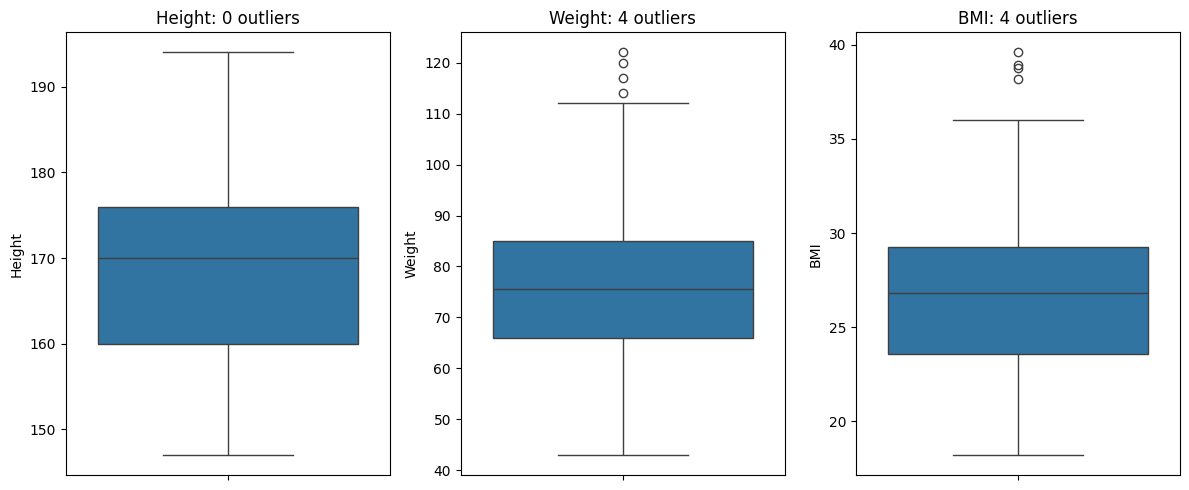

In [11]:
def analyze_outliers(df, columns):    
    # Single figure with subplots
    fig, axes = plt.subplots(1, len(columns), figsize=(4*len(columns), 5))
    if len(columns) == 1:
        axes = [axes]
        
    for i, col in enumerate(columns):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(f"{col}: {len(outliers)} outliers")
        
        # Print outlier details if any
        print(f"\n{col} outliers ({len(outliers)} found):")
        if len(outliers) > 0:
            print(outliers[col].to_string())
        
    plt.tight_layout()
    plt.show()


analyze_outliers(data, ['Height', 'Weight', 'BMI'])

As we don't have outliers in height, we will use the mean to calculate the missing values. On the contrary, as we have outliers in weight, we will use the median. We will be able to fill the missing BMI values with the calculated height and weight.

In [12]:
mean_height = data['Height'].mean()
median_height= data['Height'].median()
print('Mean height', mean_height)
print('Median height', median_height)

Mean height 169.21019108280254
Median height 170.0


In [13]:
def fill_missing(df, column, value):
    missing_before = df[column].isna().sum()
    
    if missing_before == 0:
        print(f"No missing values in column '{column}' to fill")
        return df
        
    # Fill missing values
    df[column] = df[column].fillna(value)
    missing_after = df[column].isna().sum()
    filled_count = missing_before - missing_after
    
    print(f"Filled {filled_count} missing values in '{column}' with {value}")
    return df

data = fill_missing(data, 'Height', mean_height)
data = fill_missing(data, 'Weight', median_height)
data = fill_missing_bmi_values(data)

Filled 33 missing values in 'Height' with 169.21019108280254
Filled 34 missing values in 'Weight' with 170.0
BMI calculation statistics:
- 35 missing BMI values were calculated
- 0 BMI values remain missing


In [14]:
def check_missing_values(df, columns):
    if isinstance(columns, str):
        columns = [columns]
    
    for column in columns:
        missing_count = df[column].isna().sum()
        total_count = len(df)
        percent_missing = (missing_count / total_count) * 100
        
        print(f"- {column}: {missing_count} missing values ({percent_missing:.1f}%)")
    
    return

check_missing_values(data, ['Height', 'Weight', 'BMI'])

- Height: 0 missing values (0.0%)
- Weight: 0 missing values (0.0%)
- BMI: 0 missing values (0.0%)


Now we'll focus on clearly determining what will be the target variable (labels) for both Model B and Model C, representing the SOO and sub-regions classification tasks respectively.

For Part 1 we will focus on the SOO classification, which is a binary classification task between LVOT and RVOT. We start inspecting the current column 'SOO_chamber' in the demographic data from the loaded `.pkl` file:

In [15]:
print(data['SOO_chamber'].value_counts())

SOO_chamber
RVOT                 76
Right ventricle      57
LVOT                 36
Coronary sinus        8
Tricuspid annulus     6
Mitral annulus        4
Left ventricle        3
Name: count, dtype: int64


As we can see, this data file has a problem: the values on the 'SOO_chamber' column are more in detail than we need.

This is why we load the first sheet of the first `.xlxs`, which maps these different 'SOO' labels to a value on the interesting column 'SOO_chamber', where only LVOT and RVOT (target classification) are indicated.

Not only that, but on this excel file we can also see the mapping of the sub-regions, stored in 'Region_Simplified' column of the same sheet, which we will use later for Model C.

In [16]:
labels_sheet1 = pd.read_excel(os.path.join(extract_dir, 'labels_FontiersUnsupervised.xlsx'))
labels_sheet1 = pd.DataFrame(labels_sheet1)
labels_sheet1.dropna(inplace=True)
display(labels_sheet1)

,SOO,SOO_Chamber,Automatic_SOO,Region_Simplified
0,LVOT cúspide derecha (cerca de la comisura),LVOT,RCC,RCC
1,RVOT supravalvular anterolateral,RVOT,RVOT Anterior,RVOTFREEWALL
2,RVOT anterior,RVOT,RVOT Anterior,RVOTFREEWALL
3,RVOT posteroseptal,RVOT,RVOT LateroSeptal,RVOTSEPTUM
4,LVOT intersenos de Valsalva dcho-izdo,LVOT,Intersinus,COMMISSURE
...,...,...,...,...
114,Postero Septal Subvalvular,RVOT,RVOT Septal,RVOTSEPTUM
115,RCC,LVOT,RCC,RCC
116,RVOT,RVOT,RVOT Lateral,RVOTFREEWALL
117,Summit,LVOT,LVOT Summit,SUMMIT


In [19]:
def standardize_chambers(df, mapping_df):
    """
    Map SOO_chamber values to standardized LVOT/RVOT categories with detailed logging.
    
    Args:
        df: DataFrame with SOO_chamber column
        mapping_df: DataFrame with SOO and SOO_Chamber mapping columns
    """
    # Create mapping dictionary
    mapping = dict(zip(mapping_df['SOO'], mapping_df['SOO_Chamber']))
    
    # Apply mapping to create new column
    df['SOO_Standard'] = df['SOO_chamber'].map(mapping)
    
    # Count mapped and unmapped values
    mapped = df['SOO_Standard'].notna().sum()
    unmapped = df['SOO_Standard'].isna().sum()
    
    # Show mapping results
    print(f"Mapped {mapped} values ({mapped/len(df)*100:.1f}%)")
    print(f"Unmapped {unmapped} values ({unmapped/len(df)*100:.1f}%)")
    
    # Show unmapped values if any exist
    if unmapped > 0:
        print("\nUnmapped SOO_chamber values:")
        unmapped_values = df.loc[df['SOO_Standard'].isna(), 'SOO_chamber'].unique()
        for val in unmapped_values:
            count = df.loc[df['SOO_chamber'] == val].shape[0]
            print(f"  {val}: {count} occurrences")
    
    # Show distribution of standardized values
    print("\nDistribution of standardized SOO chambers:")
    value_counts = df['SOO_Standard'].value_counts()
    for chamber, count in value_counts.items():
        print(f"  {chamber}: {count} cases ({count/len(df)*100:.1f}%)")

# Apply the standardization with improved logging
standardize_chambers(data, labels_sheet1)

# Display the mapping results
display(data[['SOO_chamber', 'SOO_Standard']].head(10))

Mapped 112 values (58.9%)
Unmapped 78 values (41.1%)

Unmapped SOO_chamber values:
  Right ventricle: 57 occurrences
  Coronary sinus: 8 occurrences
  Tricuspid annulus: 6 occurrences
  Left ventricle: 3 occurrences
  Mitral annulus: 4 occurrences

Distribution of standardized SOO chambers:
  RVOT: 76 cases (40.0%)
  LVOT: 36 cases (18.9%)


,SOO_chamber,SOO_Standard
P186,Right ventricle,NaN
P245,RVOT,RVOT
P292,LVOT,LVOT
P205,Right ventricle,NaN
P066,RVOT,RVOT
P172,Right ventricle,NaN
P132,LVOT,LVOT
P187,LVOT,LVOT
P052,LVOT,LVOT
P147,RVOT,RVOT



## 3. ECG signal preprocessing

## 4. Model A: Dimensionality reduction for ECG signals

## 5. Interpreting Model A

## 6. Preparing data for training for the two tasks

## 7. Model B: Classification of the SOO

## 8. Interpreting Model B

## 9. Model C: Classification of the sub-regions

## 10. Interpreting Model C

## 11. Final model evaluation and exporting for inference